In [3]:
import os
import glob
import numpy as np
import cv2
import pickle
import time
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
from random import randrange

In [4]:
basedir = 'input/vehicles/'
image_dirs = os.listdir(basedir)
cars = []
for img_dir in image_dirs:
    cars.extend(glob.glob(basedir+img_dir+'/*'))
    
print('Number of vehicle images found:', len(cars))

# Save all vehicle file names to cars.txt
with open('input/cars.txt', 'w') as f:
    for fname in cars:
        f.write(fname+'\n')

# Do the same for non-vehicle images
basedir = 'input/non-vehicles/'
image_dirs = os.listdir(basedir)
non_cars = []
for img_dir in image_dirs:
    non_cars.extend(glob.glob(basedir+img_dir+'/*'))

print('Number of non-vehicle images found:', len(non_cars))
# Save all non-vehicle file names to non_cars.txt
with open('input/non_cars.txt', 'w') as f:
    for fname in non_cars:
        f.write(fname+'\n')


Number of vehicle images found: 8792
Number of non-vehicle images found: 8968


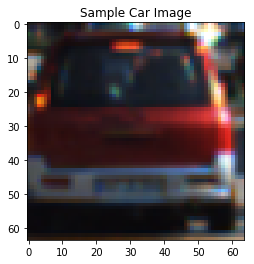

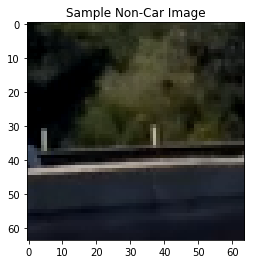

In [5]:
car_image = mpimg.imread(cars[randrange(0, len(cars))])
non_car_image = mpimg.imread(non_cars[randrange(0, len(cars))])

plt.imshow(car_image)
plt.title('Sample Car Image')
plt.show()

plt.imshow(non_car_image)
plt.title('Sample Non-Car Image')
plt.show()

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):

    # Return features and image if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False, visualise=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    # Else only return features
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, visualise=vis,
                       feature_vector=feature_vec)
        return features



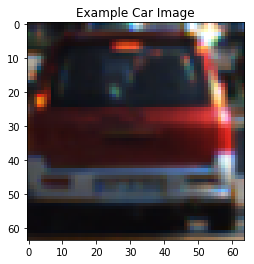

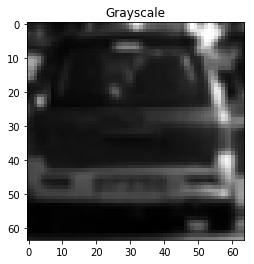

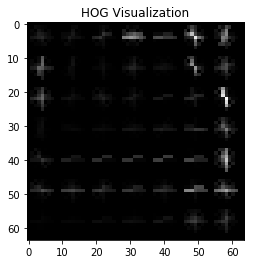

In [7]:
gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(img=gray, orient=10, pix_per_cell=9, 
                                       cell_per_block=4, vis=True, 
                                       feature_vec=False)

# Plot the examples
plt.imshow(car_image)
plt.title('Example Car Image')
plt.show()

plt.imshow(gray, cmap='gray')
plt.title('Grayscale')
plt.show()

plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()


In [8]:

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    return hist_features


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors
    features = []
    for fname in imgs:
        file_features = []
        # Read in image from disk
        image = mpimg.imread(fname)
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    return features


def get_data():
    # Read in car / non-car images
    cars = []
    with open('input/cars.txt', 'r') as f:
        for fname in f:
            cars.append(fname.rstrip('\n'))
    f.close()

    non_cars = []
    with open('input/non_cars.txt', 'r') as f:
        for fname in f:
            non_cars.append(fname.rstrip('\n'))
    f.close()

    return np.array(cars), np.array(non_cars)



In [9]:
# Get image file names
cars, non_cars = get_data()
# Print number of car and non-car images
print('Number of vehicle images found:', len(cars))
print('Number of non-vehicle images found:', len(non_cars))

# Define feature parameters
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

# Log time to extract features
t = time.time()

car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
noncar_features = extract_features(non_cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)

# Print time for extracting features
print(time.time()-t, 'Seconds to compute features...')

# Save features for training classifier
pickle.dump(car_features, open('car_features.p', 'wb'))
pickle.dump(noncar_features, open('noncar_features.p', 'wb'))


Number of vehicle images found: 8792
Number of non-vehicle images found: 8968
119.34588098526001 Seconds to compute features...


In [15]:
def train(car_features, noncar_features):
    # Combine features for training
    X = np.vstack((car_features, noncar_features)).astype(np.float64)
    # Fit a per column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector (1 for cars, 0 for noncars)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

    # Split data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

    # Train using linear SVC
    svc = LinearSVC()
    # Log training time
    t = time.time()
    # Fit classifier to data
    svc.fit(X_train, y_train)
    # Get test accuracy
    acc = round(svc.score(X_test, y_test), 4)
    # Return classifier and test accuracy
    return svc, acc, X_scaler

In [16]:
# Load features data
car_features = pickle.load(open('car_features.p', 'rb'))
noncar_features = pickle.load(open('noncar_features.p', 'rb'))

# Log training time
t = time.time()
# Train classifier on car and noncar features
svc, acc, scaler = train(car_features, noncar_features)
# Print training time
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Print test accuracy
print('Test Accuracy of SVC:', acc)

# Save classifier for future use/making predictions
joblib.dump(svc, 'classifier.pkl')
pickle.dump(scaler, open('scaler.p', 'wb'))


78.4 Seconds to train SVC...
Test Accuracy of SVC: 0.9893


In [20]:
heatmaps = []
heatmap_sum = np.zeros((720, 1280)).astype(np.float64)

In [40]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def find_vehicles(img, scale, ystart, ystop, pix_per_cell, cell_per_block, orient, spatial_size, hist_bins):
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:, :, 0])
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)
                heatmap[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] += 1

    return draw_img, heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_bounding_boxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

def process_image(img):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32

    ystart = 400
    ystop = 656
    scale = 1.5
    out_img, heat_map = find_vehicles(img, scale=scale, ystart=ystart, ystop=ystop,
                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                  orient=orient, spatial_size=spatial_size, hist_bins=hist_bins)

    global heatmap_sum
    global heatmaps
    heatmap_sum = heatmap_sum + heat_map
    heatmaps.append(heat_map)
    if len(heatmaps) > 15:
        old_heatmap = heatmaps.pop(0)
        heatmap_sum -= old_heatmap
        heatmap_sum = np.clip(heatmap_sum, 0.0, 1000000.00)
    heatmap_avg = np.divide(heatmap_sum, len(heatmaps))
    heatmap_avg_thresh = apply_threshold(heatmap_avg, 1.5)
    labels = label(heatmap_avg_thresh)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_bounding_boxes(np.copy(img), labels)
    return draw_img

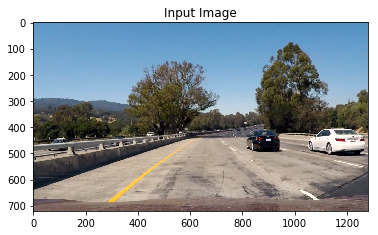

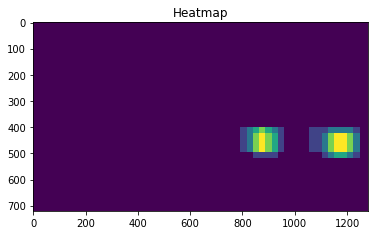

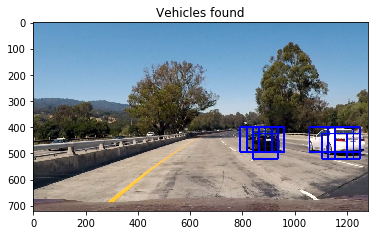

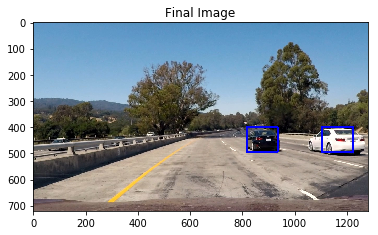

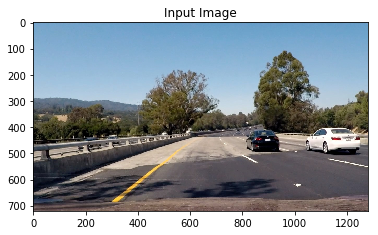

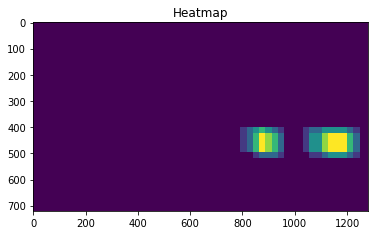

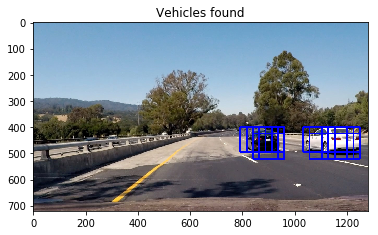

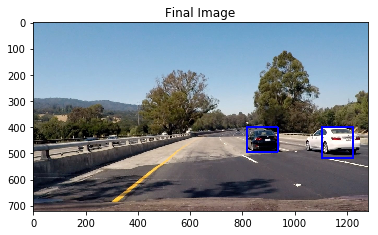

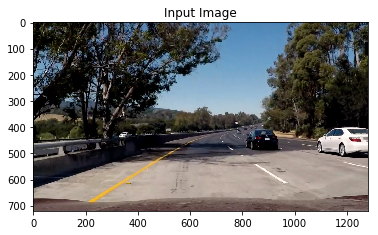

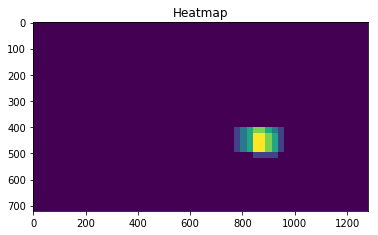

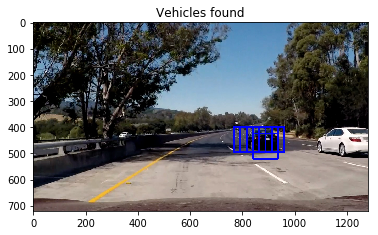

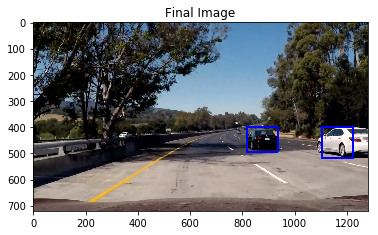

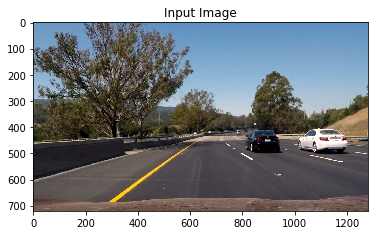

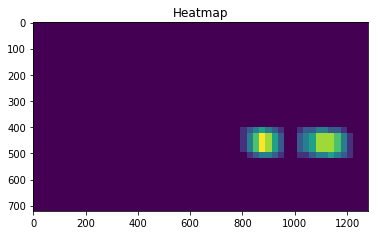

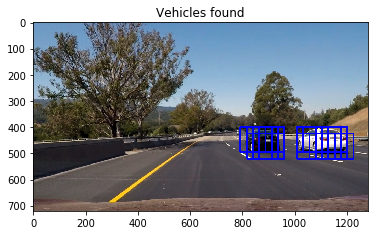

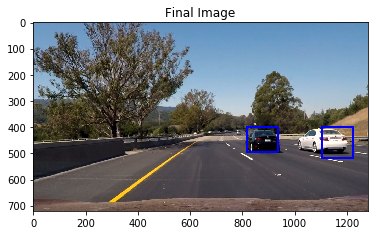

In [44]:
# Load classifier for predicting cars
svc = joblib.load('classifier.pkl')
X_scaler = pickle.load(open('scaler.p', 'rb'))
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32

ystart = 400
ystop = 656
scale = 1.5


for file in ["test1.jpg", "test4.jpg", "test5.jpg", "test6.jpg"]:
    img = mpimg.imread('test_images/%s'%file)
    draw_img = process_image(img)
    out_img, heat_map = find_vehicles(img, scale=scale, ystart=ystart, ystop=ystop,
                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                  orient=orient, spatial_size=spatial_size, hist_bins=hist_bins)

    plt.imshow(img)
    plt.title('Input Image')
    plt.show()

    plt.imshow(heat_map)
    plt.title('Heatmap')
    plt.show()

    plt.imshow(out_img)
    plt.title('Vehicles found')
    plt.show()

    
    plt.imshow(draw_img)
    plt.title('Final Image')
    plt.show()

In [39]:
# Detect cars in project video and save output
test_output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [11:37<00:00,  1.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))
